# Using DIPZ

In [50]:
"""
Using dipz with keras
"""
#'Take only this many inputs (with no args %(const)s)'
_h_take_first = 'Take only this many inputs (with no args %(const)s)'  

# TODO: clean up these hardcoded values
MASK_VALUE = 999
MERGED_NODES = [32]*4

# local libs
from layers import Sum
from utils import gaussian_loss
from utils import TRANSFORMS
from utils import scale
from utils import renamed
from utils import build_feature
from utils import get_gaussian_loss_prec

# mlearnin libs
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.layers import (
    Dense, TimeDistributed, Input, Concatenate, Masking
)
from keras.utils.generic_utils import CustomMaskWarning

# the data libs
import h5py
import json

# random python utility libs
from argparse import ArgumentParser
from pathlib import Path
import warnings

# A function to define and gets the config file 
def get_config(config_path):
    with open(config_path) as cfg:
        config = json.load(cfg)
    return dict(
        jetfeatnames=config["jetfeatnames"],
        trackfeatnames=config["trackfeatnames"],
        targetfeatnames=config["targetfeatnames"],
        batch_size=config["batch_size"],
        epoch_size=config["epoch_size"],
        number_epochs=config["number_epochs"],
        learning_rate=config["lr"],
        tracknodes=config['tracknodes'],
        jetnodes=config['jetnodes'],
    )

# A function that defines and gets the neural network model
def get_model(config, mask_value):
    n_track_inputs = len(config['trackfeatnames'])
    track_inputs = Input(shape=(None,n_track_inputs))

    n_jet_inputs = len(config['jetfeatnames'])
    jet_inputs = Input(shape=(n_jet_inputs))

    # add jet layers
    x = jet_inputs
    for nodes in config['jetnodes']:
        x = Dense(units=nodes, activation='relu')(x)
    jet_latent = x

    # add track layers
    x = track_inputs
    x = Masking(mask_value=mask_value)(x)
    for nodes in config['tracknodes']:
        x = TimeDistributed(Dense(nodes, activation='relu'))(x)
    x = Sum()(x)
    track_latent = x

    # merge the layers
    merged = Concatenate()([jet_latent, track_latent])
    # todo: not clear how many additonal processing layers we should
    # add here
    x = merged
    for nodes in MERGED_NODES:
        x = Dense(nodes, activation='relu')(x)
    out_latent = x
    outputs = keras.layers.Dense(units=2)(out_latent)
    model = keras.Model(
        inputs=[jet_inputs, track_inputs],
        outputs=outputs)
    # print the summary
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=gaussian_loss)
    return model

# A function that imports the dataset we will be working on
def get_dataset(h5file_path, config, mask_value, take_first=False):
    """
    We make some hardcoded transformations to normalize these inputs
    """

    # pt is log transformed
    # Z0 is divided by 50
    # target is divided by 50

    trf = TRANSFORMS
    # identy function to pass through things that aren't listed above
    def ident(x):
        return x

    sl = slice(None,None,None)
    if take_first:
        sl = slice(0,take_first,None)

    with h5py.File(h5file_path) as h5file:
        # get track array
        td = h5file['super_tracks']
        tfn = config['trackfeatnames']
        # we can pass through NaNs here
        with np.errstate(invalid='ignore'):
            trackstack = [trf.get(x,ident)(td[x,sl,...]) for x in tfn]
        track_array = np.stack(trackstack, axis=2)
        invalid = np.isnan(td['pt',sl])
        track_array[invalid,:] = mask_value

        # get jet array
        jd = h5file['jets']
        jfn = config['jetfeatnames']
        jetstack = [trf.get(x,ident)(jd[x,sl]) for x in jfn]
        jet_array = np.stack(jetstack, axis=1)

        # get targets
        tfn = config['targetfeatnames']
        targetstack = [trf.get(x,ident)(jd[x,sl]) for x in tfn]
        target_array = np.stack(targetstack, axis=1)

    return jet_array, track_array, target_array


# A function that predicts the output, produces target arrays and returns them
def dump_prediction(model, jet_inputs, track_inputs, targets):
    pred = model.predict([jet_inputs, track_inputs])
    z = pred[:,0]
    zhat = targets[:,0]
    widths = np.sqrt(np.exp(-pred[:,1])) #Standard Deviation
    sigma = (z - zhat) / widths
    print(np.stack([z, zhat, widths, sigma]).T[:20])
    return z, zhat, widths, sigma

# A function that gets the config file, model, dataset, inputs weights to the model, 
#makes predictions and saves them
def run(z, zhat, widths, sigma):
    mask_value = MASK_VALUE
    config = get_config("./regress.json")
    model = get_model(config, mask_value=mask_value)
    model.load_weights('outputs/weights.h5')
    jet_inputs, track_inputs, targets = get_dataset(
    "../output_latest_with_counter.h5", config, mask_value)
    z, zhat, widths, sigma = dump_prediction(model, jet_inputs, track_inputs, targets)
    return z, zhat, widths, sigma

In [51]:
# Defining our containers for the output results
z, zhat, widths, sigma = [], [], [], []

In [52]:
z, zhat, widths, sigma = run(z, zhat, widths, sigma)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 8)]    0           []                               
                                                                                                  
 masking_1 (Masking)            (None, None, 8)      0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 time_distributed_4 (TimeDistri  (None, None, 16)    144         ['masking_1[0][0]']              
 buted)                                                                                     

In [53]:
z

array([ 0.19077502,  0.23109658,  0.17533515, ..., -0.44598377,
       -0.4903022 , -0.35610002], dtype=float32)

22930


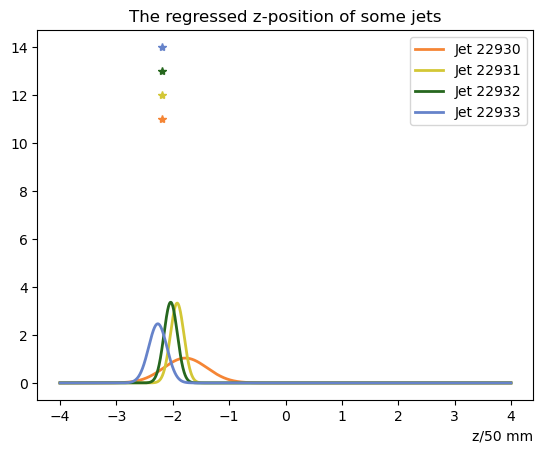

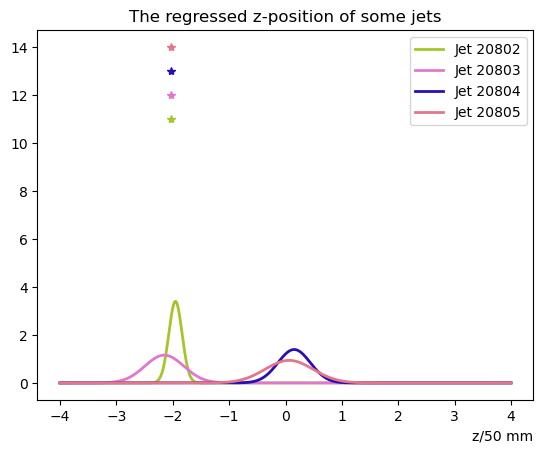

In [54]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import random

#Finding the events with 4 jets
uniques = np.unique(zhat)
c = 0
values = []
for value in uniques:
    if len(zhat[zhat == value]) == 4:
        values.append(value)

print(np.where(zhat == values[0])[0][0])

#Plotting some events with 4 jets
for i in range(2): 
    x = np.arange(-4, 4, 0.001)
    ind_of_first = np.where(zhat == values[i])[0][0]
    n = np.arange(ind_of_first,ind_of_first+4,1)
    #Generating random colors for the plot
    color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
           for j in range(len(n))]
    ic = 0      #color counter

    for i in n:
        plt.plot(x, norm.pdf(x, z[i], widths[i]), color=color[ic], linewidth=2, label='Jet '+str(i))
        plt.plot(zhat[i], 11 + ic, marker='*', color=color[ic])
        ic = ic + 1
    plt.xlabel("z/50 mm", loc='right')
    plt.title('The regressed z-position of some jets')
    plt.legend()
    plt.show()
    #plt.cla()

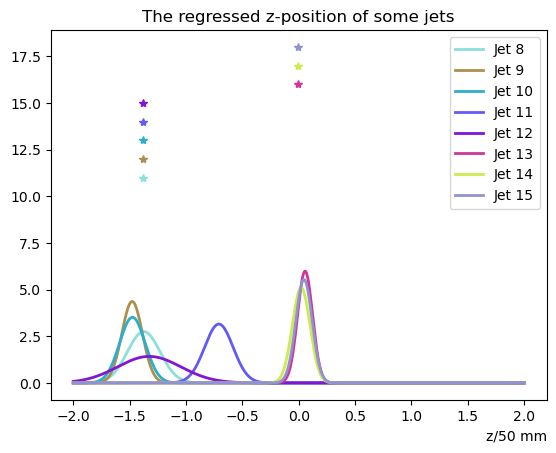

In [55]:
'''Plotting the jets' regressed z-position'''
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.pyplot as plt
import random


#z-axis ranges from -2 and 2 with .001 steps
x = np.arange(-2, 2, 0.00001)
n = np.arange(8,16,1)

#Generating random colors for the plot
color=["#"+''.join([random.choice('0123456789ABCDEF') for i in range(6)])
       for j in range(len(n))]
ic = 0      #color counter

for i in n:
    plt.plot(x, norm.pdf(x, z[i], widths[i]), color=color[ic], linewidth=2, label='Jet '+str(i))
    plt.plot(zhat[i], 11 + ic, marker='*', color=color[ic])
    ic = ic + 1
    """plt.plot(x, norm.pdf(x, z[6], widths[6]), color='red', linewidth=2, label='Second Jet')
    plt.plot(zhat[6], 11, marker='*', color="red")
    plt.plot(x, norm.pdf(x, z[7], widths[7]), color='green', linewidth=2, label='Third Jet')
    plt.plot(zhat[7], 12, marker='*', color="green")
    plt.plot(x, norm.pdf(x, z[8], widths[8]), color='orange', linewidth=2, label='Fourth Jet')
    plt.plot(zhat[8], 13, marker='*', color="orange")
    plt.plot(x, norm.pdf(x, z[9], widths[9]), color='purple', linewidth=2, label='Fifth Jet')
    plt.plot(zhat[9], 14, marker='*', color="purple")
    """
plt.xlabel("z/50 mm", loc='right')
plt.title('The regressed z-position of some jets')
plt.legend()
plt.show()
#plt.cla()

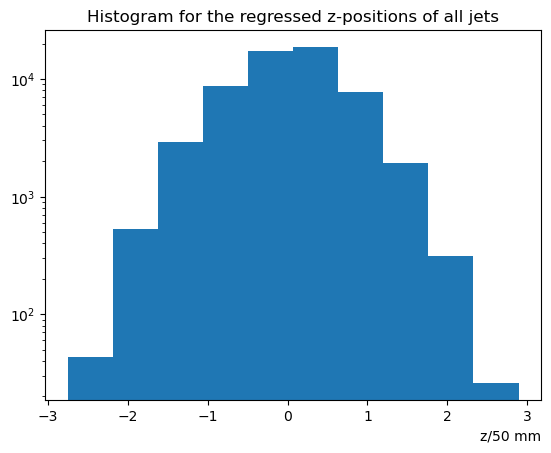

In [56]:
"""Plotting a histogram of the regressed z-positions of all jets"""
plt.hist(z, bins=10)
plt.yscale("log")
plt.title('Histogram for the '+ 'regressed z-positions' +' of all jets')
plt.xlabel("z/50 mm", loc='right')
plt.show()

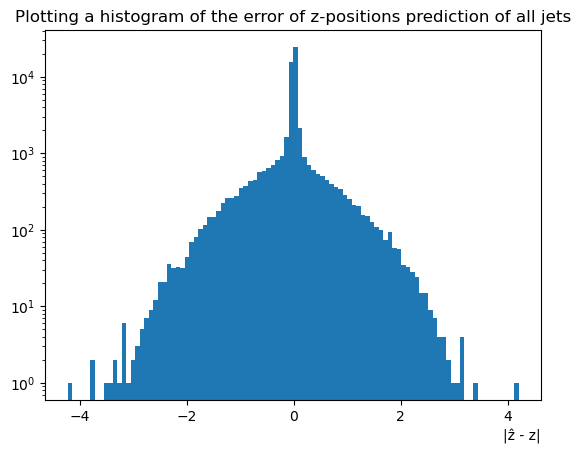

In [57]:
"""Plotting a histogram of the error of z-positions prediction of all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

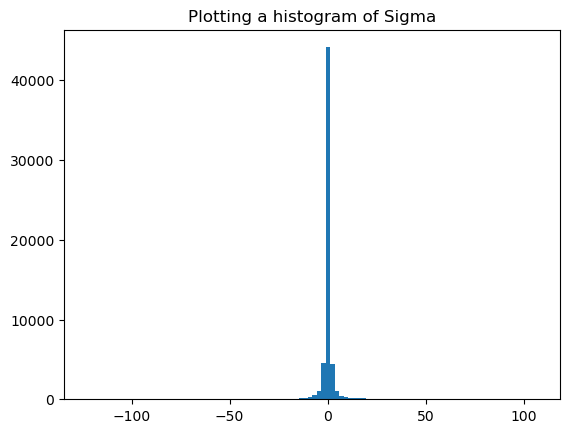

In [58]:
plt.hist(sigma, bins=100)
#plt.yscale('log')
plt.title('Plotting a histogram of Sigma')
plt.xlabel("", loc='right')
plt.show()

In [59]:
print(np.std(sigma))

4.3697853


# Accessing the Dataset

In [60]:
from turtle import title
from h5py import File
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math

In [61]:
#Opening the HDF5 File
input_file = "../output_latest_with_counter.h5"
data = File(input_file, 'r')

In [62]:
#Accessing the 'Jets' Dataset
print("List of available datasets: " + str(list(data.keys())))
jets = data['jets']

List of available datasets: ['jets', 'super_tracks', 'super_tracks_associated', 'super_tracks_fixed_cone']


In [63]:
print("The attributes of each element of the dataset (jets): " + str(jets.dtype.fields.keys()))

The attributes of each element of the dataset (jets): dict_keys(['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty'])


In [64]:
print(jets[jets['eventNumber'] == 1856003]['eventNumber'])

[1856003 1856003 1856003 1856003 1856003 1856003 1856003]


In [65]:
print(jets['eventNumber'])

[1856001 1856001 1856001 ... 1865536 1865536 1865536]


In [66]:
super_tracks = data['super_tracks']
print("The attributes of each element of the dataset (super_tracks): " + str(super_tracks.dtype.fields.keys()))

The attributes of each element of the dataset (super_tracks): dict_keys(['numberOfInnermostPixelLayerHits', 'numberOfNextToInnermostPixelLayerHits', 'numberOfPixelHits', 'numberOfSCTHits', 'numberOfPixelHoles', 'numberOfSCTHoles', 'chiSquared', 'numberDoF', 'radiusOfFirstHit', 'qOverP', 'pt', 'qOverPUncertainty', 'd0', 'd0Uncertainty', 'IP2D_signed_d0', 'phiUncertainty', 'thetaUncertainty', 'deta', 'dphi', 'dr', 'ptfrac', 'z0RelativeToBeamspot', 'z0RelativeToBeamspotUncertainty', 'valid'])


In [67]:
print(super_tracks['z0RelativeToBeamspot'])

[[ -7.3120856  21.448177   11.218379  ...         nan         nan
          nan]
 [  9.253447   11.053585    9.829176  ...         nan         nan
          nan]
 [  8.966665  -12.572241   10.536818  ...         nan         nan
          nan]
 ...
 [ 25.052536   90.40664    -2.7029438 ...         nan         nan
          nan]
 [ 87.42252    -4.108758   19.201859  ...         nan         nan
          nan]
 [ 78.56919   -29.030123  -27.214304  ...         nan         nan
          nan]]


In [68]:
print(np.sum(jets['n_super_tracks'] > 40))

34


In [69]:
print(len(jets))

58367


In [70]:
print(z.shape)

(58367,)


In [71]:
print(jets)

<HDF5 dataset "jets": shape (58367,), type "|V92">


In [72]:
print(z[0])

0.19077502


In [73]:
print(jets['dipz_z'][0])

0.19077505


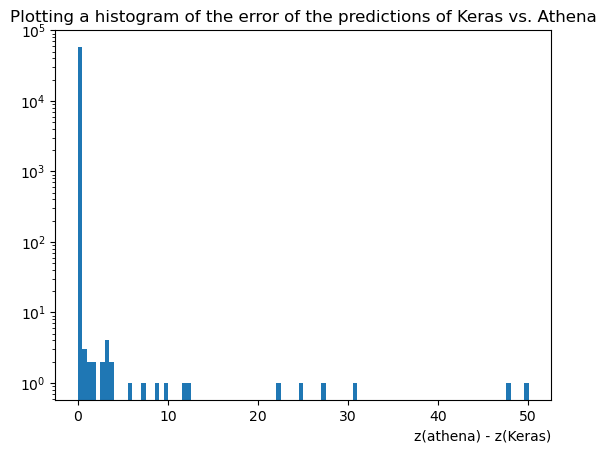

In [74]:
plt.hist(np.abs(jets['dipz_z']-z) * 50, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

2


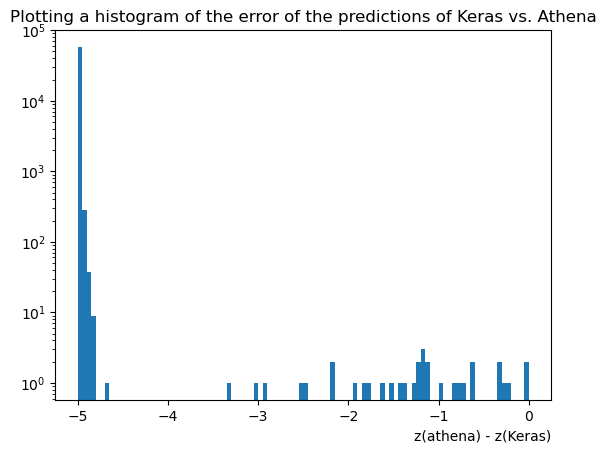

In [94]:
سين = 2
print(سين)
plt.hist(np.log10(np.abs(jets['dipz_z']-z) + 10**-5), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

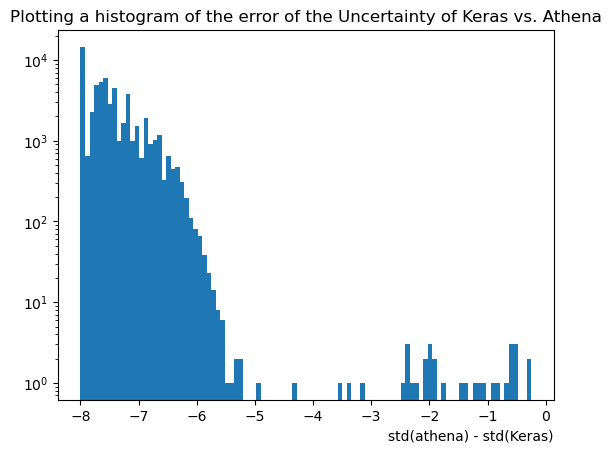

In [102]:
c = np.sqrt(np.exp(-jets['dipz_negLogSigma2']))-widths
plt.hist(np.log10(np.abs(c) + 10**-8), bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the Uncertainty of Keras vs. Athena')
plt.xlabel("std(athena) - std(Keras)", loc='right')
plt.show()

In [77]:
jets['dipz_z'].dtype

dtype('<f4')

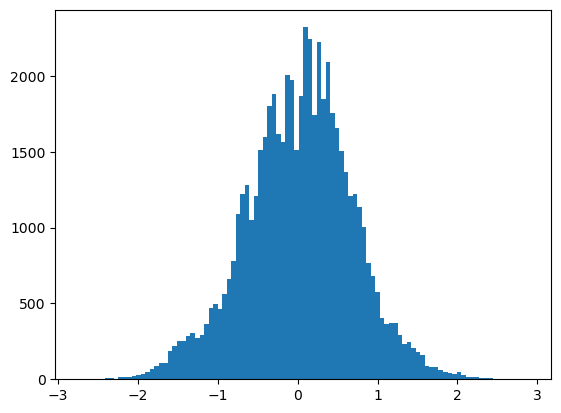

In [78]:
plt.hist(jets['dipz_z'], bins=100)
#plt.yscale('log')
plt.show()

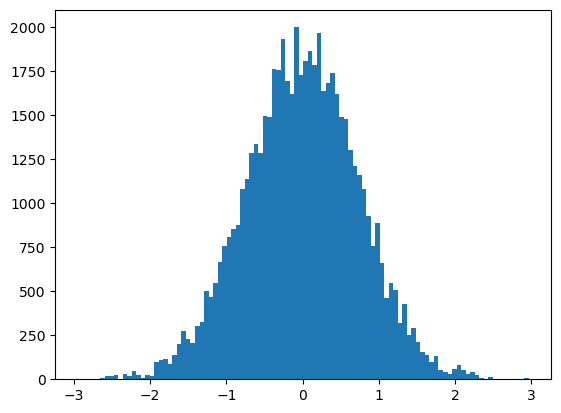

In [79]:
plt.hist(zhat, bins=100)
#plt.yscale('log')
plt.show()

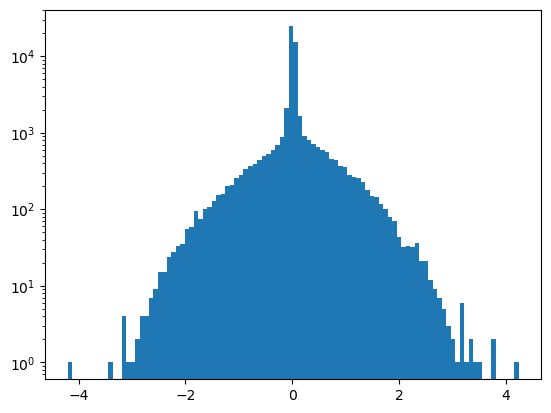

In [80]:
plt.hist(jets['dipz_z']-zhat, bins=100)
plt.yscale('log')
plt.show()

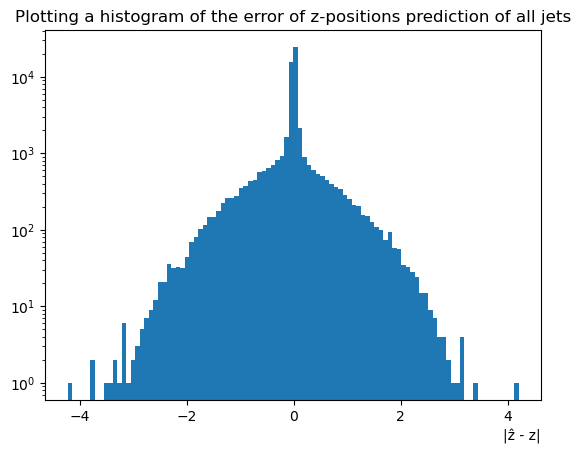

In [81]:
"""Plotting a histogram of the error of z-positions predictionof all jets"""
plt.hist(zhat-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of z-positions prediction of all jets')
plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

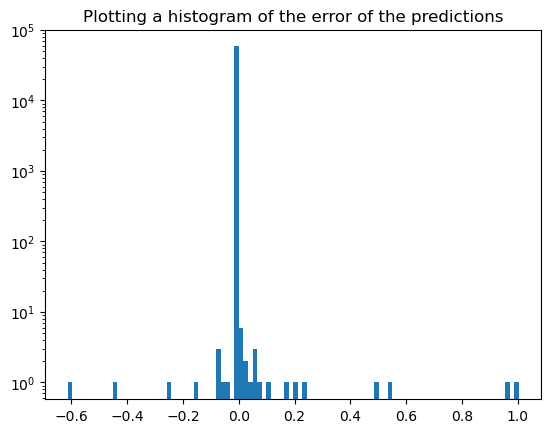

In [82]:
plt.hist(jets['dipz_z']-z, bins=100)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions')
#plt.xlabel("|z\u0302 - z|", loc='right')
plt.show()

In [83]:
print(jets["n_tracks_nn"])
print(jets["n_super_tracks"])

[11.  6.  8. ... 18. 15. 15.]
[11  6  8 ... 18 15 15]


In [84]:
x = jets["n_tracks_nn"] == jets["n_super_tracks"]
print(False in x)

False


In [85]:
d = jets['dipz_z']-z
c = d > 0.01 
print(len(d))
print(np.count_nonzero(c))

58367
17


In [86]:
regions = [10**-2,10**-3,10**-4,10**-5,10**-6,10**-7,10**-8,10**-9,10**-10]
for i in regions:
    c = d > i 
    n = np.count_nonzero(c)
    print("The number predictions with error bigger than " + str(i) + " is " + str(n))

The number predictions with error bigger than 0.01 is 17
The number predictions with error bigger than 0.001 is 20
The number predictions with error bigger than 0.0001 is 21
The number predictions with error bigger than 1e-05 is 21
The number predictions with error bigger than 1e-06 is 281
The number predictions with error bigger than 1e-07 is 10070
The number predictions with error bigger than 1e-08 is 23411
The number predictions with error bigger than 1e-09 is 23934
The number predictions with error bigger than 1e-10 is 23937


In [87]:
s = jets['dipz_negLogSigma2']-widths
max = np.argmax(s)

In [88]:
jet_intended = jets[max]
jet_variables = ['pt', 'HadronConeExclTruthLabelPt', 'n_tracks_nn', 'eta', 
                 'fastDips_pb', 'fastDips_pc', 'fastDips_pu', 'dipz_z', 'dipz_negLogSigma2', 
                 'HadronConeExclTruthLabelID', 'HadronConeExclExtendedTruthLabelID', 'jetPtRank', 
                 'n_super_tracks', 'n_super_tracks_associated', 'n_super_tracks_fixed_cone', 'mcEventWeight', 
                 'eventNumber', 'averageInteractionsPerCrossing', 'actualInteractionsPerCrossing', 
                 'nPrimaryVertices', 'primaryVertexDetectorZ', 'primaryVertexDetectorZUncertainty']
for var in jet_variables:
    c = jet_intended[var]
    print("The jet's " + var + " is " + str(c))

The jet's pt is 598082.75
The jet's HadronConeExclTruthLabelPt is nan
The jet's n_tracks_nn is 51.0
The jet's eta is -0.3856283
The jet's fastDips_pb is 0.082168095
The jet's fastDips_pc is 0.27310917
The jet's fastDips_pu is 0.64472276
The jet's dipz_z is 0.49536124
The jet's dipz_negLogSigma2 is 10.145545
The jet's HadronConeExclTruthLabelID is 0
The jet's HadronConeExclExtendedTruthLabelID is 0
The jet's jetPtRank is 0
The jet's n_super_tracks is 51
The jet's n_super_tracks_associated is 51
The jet's n_super_tracks_fixed_cone is 62
The jet's mcEventWeight is 813.566
The jet's eventNumber is 1865827
The jet's averageInteractionsPerCrossing is 64.5
The jet's actualInteractionsPerCrossing is 64.5
The jet's nPrimaryVertices is 25
The jet's primaryVertexDetectorZ is 29.403414
The jet's primaryVertexDetectorZUncertainty is 0.011197806


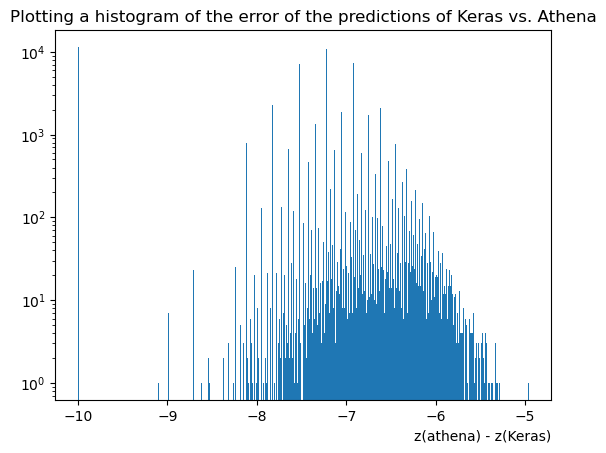

In [109]:
idx = jets['n_super_tracks'] < 40
c = jets['dipz_z']-z
plt.hist(np.log10(np.abs(c[idx])+ 1e-10) , bins=500)
plt.yscale('log')
plt.title('Plotting a histogram of the error of the predictions of Keras vs. Athena')
plt.xlabel("z(athena) - z(Keras)", loc='right')
plt.show()

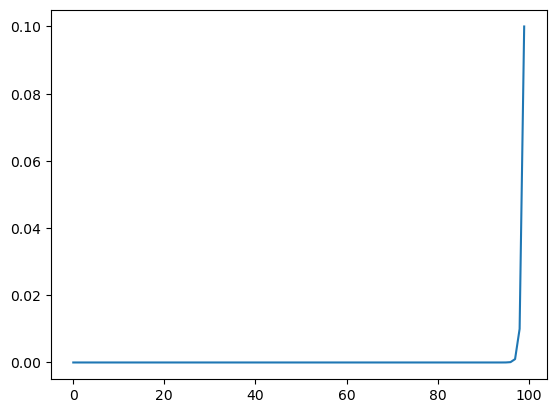

In [111]:
g = (10**np.arange(-100, 0, dtype='float32') + 1) - 1
plt.plot(g)